# Imports

In [241]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

# for Q-Q plots
import scipy.stats as stats

# from feature-engine
#from feature_engine.imputation import MeanMedianImputer
import feature_engine.imputation as imp

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [242]:
DATA_PATH = "fake_job_postings.csv"

# Complete Case Analysis
Instead of imputing missing variables, there is an option to remove missing variables.
This option is done in complete case analysis (CCA), in which all observations with a missing data in one of the variables is discarded. That means we only keep observations with data on all the variables.

**Assumptions:** Data is missing completely at random.

**Advantages:**
- No data manipulation
- Preserves variable distribution

**Limitation:**
- Discard a huge amount of data
- Introduce bias
- Remove informative information

### Load Data

In [243]:
postings = pd.read_csv(DATA_PATH)
postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Variables with missing Values

In [244]:
vars_with_na = [var for var in postings.columns if postings[var].isnull().mean() > 0]
vars_with_na

['location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

In [245]:
vars_with_no_na = [vars for vars in postings.columns if postings[vars].isnull().mean() == 0]
vars_with_no_na

['job_id',
 'title',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'fraudulent']

Conclusion: 'job_id', 'title', 'telecommuting', 'has_company_logo', 'has_questions' and 'fraudulent' do **NOT** have missing values.

### Counting Proportion of missing Values

In [246]:
# function to calculate missing data by column
postings_na = postings[vars_with_na].isnull().mean()

# Transforming the data into a dataframe
postings_na = pd.DataFrame(postings_na.reset_index())

# Renaming the columns
postings_na.columns = ['variable', 'missing_percentage']

# Sorting the dataframe by missing values
postings_na.sort_values(by='missing_percentage', ascending=False, inplace=True)

postings_na

,variable,missing_percentage
2,salary_range,0.839597
1,department,0.645805
9,required_education,0.453300
6,benefits,0.403244
8,required_experience,0.394295
11,function,0.361018
10,industry,0.274217
7,employment_type,0.194128
3,company_profile,0.185011
5,requirements,0.150727


Conclusion: Some Values have a very high percentage of missing values, lets have a look:
- 83% of all values in the 'salaray_range' column are empty (NaN), but is that bad?
- 65% of all department values are missing (e.g. Marketing etc.)
- 25% - 45% every forth to every second value is missing (how relevant are these features?)
- 15% - 20% every fifth value is missing, is it at random?
- <5% almost no values are missing, how can these be filled and are these values missing at random?

#### Salary Range

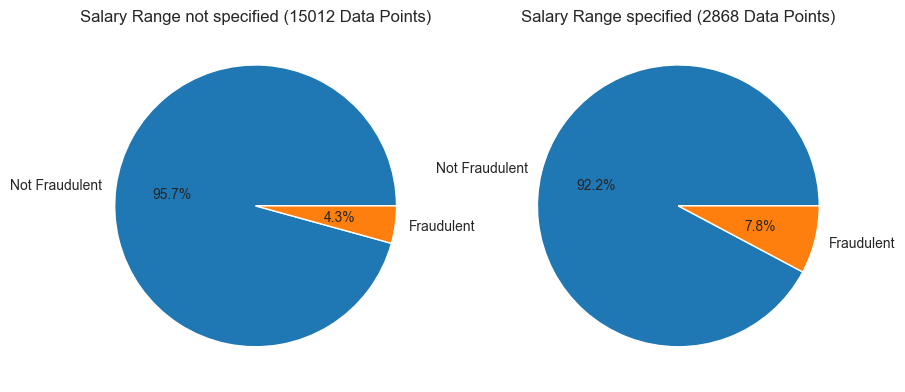

In [247]:
salary_range = postings['salary_range']
fraudulent = postings['fraudulent']

# NA = 0, else 1
salary_range = pd.DataFrame(np.where(salary_range.isnull(), 0, 1))

# combine the two columns
salary_fraudulent = pd.concat([salary_range, fraudulent], axis=1)
salary_fraudulent.columns = ['salary_range', 'fraudulent']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# salary range not specified (=0) and fraudulent as pie
salary_not_specified = salary_fraudulent[salary_fraudulent['salary_range'] == 0]
ax1.pie(salary_not_specified['fraudulent'].value_counts(), labels=['Not Fraudulent', 'Fraudulent'], autopct='%1.1f%%')
ax1.title.set_text(f'Salary Range not specified ({salary_not_specified.shape[0]} Data Points)')

# salary range specified (=1) and fraudulent as pie
salary_specified = salary_fraudulent[salary_fraudulent['salary_range'] == 1]
ax2.pie(salary_specified['fraudulent'].value_counts(), labels=['Not Fraudulent', 'Fraudulent'], autopct='%1.1f%%')
ax2.title.set_text(f'Salary Range specified ({salary_specified.shape[0]} Data Points)')

We need to further look into the salary range.

<br>

feature --> zielvariable
- missing at random
- repräsentativ
- salaray range binär (null machen wenn kein wert, 1 wenn vorhanden) zweites Df kreieren
- salary range mit kategorien plotten (Na, Ranges, Datum, Nur 1 Wert), wieviel ist prozentual angezeigt
- der höchste
- hat eas einen einfluss auf unser modell (binär)
- department ('Unspecified') --> Rare Labels
- location (splitting in 3 features land, state, city)

Alex: location <br>
Louis: salary range <br>
Drin: department, req_education und was du noch so magst

In [248]:

df_salary_binary = postings.copy()
#print(df_salary_binary['salary_range'].isnull())
#print(df_salary_binary['salary_range'].isnull().sum())

'''salary feature make binary'''
'''iterate trough salary_range column and if value is not null, set value to 1, else 0'''

for index, row in df_salary_binary.iterrows():
    if pd.isnull(row['salary_range']):
        df_salary_binary.at[index, 'salary_range'] = 0
    else:
        df_salary_binary.at[index, 'salary_range'] = 1




In [249]:

df = postings

'''split df into two dataframes, one with salary_range and one without'''
df_salary = df[df['salary_range'].notnull()]
df_no_salary = df[df['salary_range'].isnull()]
print(df_salary)
#print(df_no_salary['salary_range'].value_counts())


       job_id                                              title  \
6           7                              Head of Content (m/f)   
10         11  ASP.net Developer Job opportunity at United St...   
15         16                         VP of Sales - Vault Dragon   
23         24  Vice President, Sales and Sponsorship (Busines...   
31         32                   Software Applications Specialist   
...       ...                                                ...   
17844   17845             Sr. Scm Web Development Technical Lead   
17849   17850                             Communication Designer   
17865   17866  Portfolio Development Associate - Paris & rest...   
17867   17868                                   Admin Assistant    
17874   17875                               JavaScript Developer   

                    location          department   salary_range  \
6             DE, BE, Berlin          ANDROIDPIT    20000-28000   
10       US, NJ, Jersey City                 NaN 

In [250]:


'''make a copy of df_salary'''
df_salary_copy = df_salary.copy()


In [251]:
df_salary_copy['salary_range'] = df_salary_copy['salary_range'].str.replace('Dec', 'Date')
df_salary_copy['salary_range'] = df_salary_copy['salary_range'].str.replace('Apr', 'Date')
df_salary_copy['salary_range'] = df_salary_copy['salary_range'].str.replace('Oct', 'Date')
df_salary_copy['salary_range'] = df_salary_copy['salary_range'].str.replace('Sep', 'Date')
df_salary_copy['salary_range'] = df_salary_copy['salary_range'].str.replace('Jun', 'Date')
df_salary_copy['salary_range'] = df_salary_copy['salary_range'].str.replace('Nov', 'Date')



'''how many percent of salary_range intails 'date'  '''
print(df_salary_copy['salary_range'].str.contains('Date').sum() / len(df_salary_copy['salary_range']))


0.00906555090655509


In [252]:
''''make new df with only salary range 'Date' '''
df_salary_copy_date = df_salary_copy[df_salary_copy['salary_range'].str.contains('Date')]
print(df_salary_copy_date['salary_range'].value_counts())

10-Date    11
11-Date     3
4-Date      2
Date-20     2
2-Date      2
9-Date      1
3-Date      1
Date-15     1
8-Date      1
Date-18     1
Date-25     1
Name: salary_range, dtype: int64


In [253]:
'''how many percent of salary_range intails 'date' and are fraudulent  '''
print(df_salary_copy[df_salary_copy['fraudulent'] == 1]['salary_range'].str.contains('Date').sum() / len(df_salary_copy[df_salary_copy['fraudulent'] == 1]['salary_range']))



0.004484304932735426


In [254]:
'''create dataframe with only rows that have a salary_range that does include 'date' '''
df_salary_date = df_salary_copy[df_salary_copy['salary_range'].str.contains('Date') == True]

'''how many percent df_salary_date are fraudulent'''

print(df_salary_date['fraudulent'].sum() / len(df_salary_date['fraudulent']))
print(df_salary_copy['salary_range'])

0.038461538461538464
6          20000-28000
10       100000-120000
15       120000-150000
23       100000-120000
31         50000-65000
             ...      
17844              0-0
17849     80000-100000
17865      18000-20000
17867      18000-19000
17874     80000-100000
Name: salary_range, Length: 2868, dtype: object


In [255]:
'''remove all non numeric characters from salary_range'''

'''make a copy of df_salary'''

df_salary_copy_numeric = df_salary_copy.copy()

df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('$', '')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace(',', '')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('K', '')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('k', '')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace(' ', '')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('-', ' ')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('to', ' ')
df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('Date', ' ')


'''if there are 2 numbers in salary_range, take the average'''
for index, row in df_salary_copy_numeric.iterrows():
    if len(row['salary_range'].split()) == 2:
        df_salary_copy_numeric.at[index, 'salary_range'] = (int(row['salary_range'].split()[0]) + int(row['salary_range'].split()[1])) / 2
    else:
        df_salary_copy_numeric.at[index, 'salary_range'] = row['salary_range']

'''convert salary_range to numeric'''
df_salary_copy_numeric['salary_range'] = pd.to_numeric(df_salary_copy_numeric['salary_range'], errors='coerce')






C:\Users\Startklar\AppData\Local\Temp\ipykernel_19264\1705075487.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_salary_copy_numeric['salary_range'] = df_salary_copy_numeric['salary_range'].str.replace('$', '')


In [256]:
'''convert salary_range to numeric'''
df_salary_copy_numeric['salary_range'] = pd.to_numeric(df_salary_copy_numeric['salary_range'], errors='coerce')

print(df_salary_copy_numeric['salary_range'][6])


24000.0


In [257]:
'''what is the average salary of fraudulent jobs?'''
df_salary_copy_numeric[df_salary_copy_numeric['fraudulent'] == 1]['salary_range'].mean()

112666.06502242152

In [258]:
'''what is the average salary of non fraudulent jobs?'''
print(df_salary_copy_numeric[df_salary_copy_numeric['fraudulent'] == 0]['salary_range'].mean())

703800.0742911153


In [259]:
'''categroies for salary_range based on quartiles'''

df_salary_copy_categories = df_salary_copy_numeric.copy()

df_salary_copy_categories['salary_range'] = pd.qcut(df_salary_copy_categories['salary_range'], q=4, labels=['low', 'medium', 'high', 'very high'])


print(df_salary_copy_categories['salary_range'].value_counts())



high         725
low          719
medium       716
very high    708
Name: salary_range, dtype: int64


In [260]:
'''how many percent of all categories are fraudulent'''
print(df_salary_copy_categories['salary_range'].value_counts())
'''show percentage of fraudulent jobs in each salary_range category'''
print(df_salary_copy_categories.groupby('salary_range')['fraudulent'].sum() / df_salary_copy_categories.groupby('salary_range')['fraudulent'].count())

high         725
low          719
medium       716
very high    708
Name: salary_range, dtype: int64
salary_range
low          0.070932
medium       0.118715
high         0.053793
very high    0.067797
Name: fraudulent, dtype: float64


In [261]:
#Fraudulent höhere Gewichtung
